# Scrapper:

* Using BeautifulSoup (bs4)
* Product:  [pantalones](https://www.amazon.com/-/es/Pantalones-deportivos-ComfortSoft-EcoSmart-vell%C3%B3n/dp/B0BFXSYQDS/ref=cm_cr_arp_d_product_top?ie=UTF8)

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL de la página del producto en Amazon
url = 'https://www.amazon.com/-/es/Pantalones-deportivos-ComfortSoft-EcoSmart-vell%C3%B3n/product-reviews/B0BFXSYQDS/ref=cm_cr_unknown?ie=UTF8&reviewerType=all_reviews&filterByStar={}&pageNumber={}&language=en_US'

# Encabezados de la petición para hacerla parecer que se está accediendo desde un navegador
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0",
    "Accept-Encoding": "gzip, deflate",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,/;q=0.8",
    "DNT": "1",
    "Connection": "close",
    "Upgrade-Insecure-Requests": "1"
}

# Recorremos todas las páginas de reseñas
numPaginas = 130
stars = ["one_star", "two_star", "three_star", "four_star", "five_star"]

for star in stars:
    df = pd.DataFrame({'Valoraciones': [], 'Texto': []})
    i = 1
    while i <= numPaginas:
        next_page_url = url.format(star, str(i))

        response = requests.get(next_page_url, headers=headers)

        # Creamos un objeto BeautifulSoup con el contenido HTML de la respuesta
        soup = BeautifulSoup(response.content, 'html.parser')
        captcha_form = soup.find('form', {'action': '/errors/validateCaptcha'})
        while captcha_form:
            response = requests.get(next_page_url, headers=headers)
            soup = BeautifulSoup(response.content, 'html.parser')
            captcha_form = soup.find(
                'form', {'action': '/errors/validateCaptcha'})
        # Encontramos el elemento que contiene las reseñas
        reviews_container = soup.find('div', {'id': 'cm_cr-review_list'})
        try:
            # Encontramos todos los elementos que contienen las reseñas
            reviews = reviews_container.find_all(
                'div', {'data-hook': 'review'})
        except AttributeError:
            # Si no se encuentran reseñas, establecemos la lista de reseñas en vacío
            reviews = []

        for review in reviews:

            title = review.find('a', {'data-hook': 'review-title'})
            if title is not None:
                title = title.get_text().strip()
            else:
                title = ''

            text = review.find('span', {'data-hook': 'review-body'})
            if text is not None:
                text = text.get_text().strip()
            else:
                text = ''

            stars = review.find('i', {'data-hook': 'review-star-rating'})
            if stars is not None:
                stars = stars.get_text().split()[0]
                stars = stars.replace(',', '.')
                stars = int(float(stars))
            else:
                stars = 0

            content = title+" "+text
            if stars != 0:
                new_row = pd.DataFrame(
                    {'Valoraciones': [stars], 'Texto': [content]})
                df = pd.concat([df, new_row], ignore_index=True)

        i += 1

    df.to_csv("datasets/reviews_{}.csv".format(star), index=False)


In [3]:
import pandas as pd
import re
import numpy as np

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
from sklearn import metrics

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pelikan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/pelikan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Dataset reading

Using datasets generated by the scrapper in the dataset folder.

In [4]:
folder = "datasets/"

np.random.seed(20)
df1 = pd.read_csv(folder + "reviews_one_star.csv")
df1.Valoraciones = 1
df2 = pd.read_csv(folder + "reviews_two_star.csv")
df2.Valoraciones = 2
df3 = pd.read_csv(folder + "reviews_three_star.csv")
df3.Valoraciones = 3
df4 = pd.read_csv(folder + "reviews_four_star.csv")
df4.Valoraciones = 4
df5 = pd.read_csv(folder + "reviews_five_star.csv")
df5.Valoraciones = 5
df = pd.concat([df1,df2,df3,df4,df5],axis = 0,ignore_index=True)

In [22]:
def quitarStopWords(review):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(review)
    filtered_sentence  = [w for w in word_tokens if not w.lower() in stop_words]
    frase =  " ".join(filtered_sentence)
    return frase

def confusion(y_real, y_pred):
    conf_matrix = metrics.confusion_matrix(y_real, y_pred)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Real class', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
def mostrarFallos(y_real, y_pred):
    mask = np.array(y_pred != y_real).ravel()
    classes = np.arange(5)
    valores = np.zeros(5)
    for i in range(1,6):
        valores[i-1] = np.sum(y_real[mask] == i)
    plt.title('Fallos por clase')
    plt.bar(classes, valores, edgecolor='black', color='lightblue')
    plt.ylabel('Numero de fallos')
    plt.title("Fallos por clase")
    plt.xticks(classes, ['1','2','3','4','5'])
    plt.xlabel('Estrellas')

## PreProcessing

In [39]:

df["Texto"] = df["Texto"].apply(lambda x :re.sub(r'\W', ' ',x))
df["Texto"] = df["Texto"].apply(lambda x :re.sub(r'\s+[a-zA-Z]\s+', ' ',x))
df["Texto"] = df["Texto"].apply(lambda x :re.sub(r'\^[a-zA-Z]\s+', ' ',x))
df["Texto"] = df["Texto"].apply(lambda x :re.sub(r'\s+', ' ',x))
df["Texto"] = df["Texto"].apply(lambda x :re.sub(r'^b\s+', ' ',x))
df["Texto"] = df["Texto"].str.lower()
df["TextoClean"] = df["Texto"].apply(quitarStopWords)


def cambiarValores(valoracion):
    if valoracion == 2:
        return 1
    elif valoracion == 4:
        return 5
    else:
        return valoracion

df = df[df["Texto"].apply(lambda x: len(x.split()) > 5)]

df_red = df[df["Valoraciones"].apply(lambda x: x in [1,3,5])]


## Class distribution plots: 

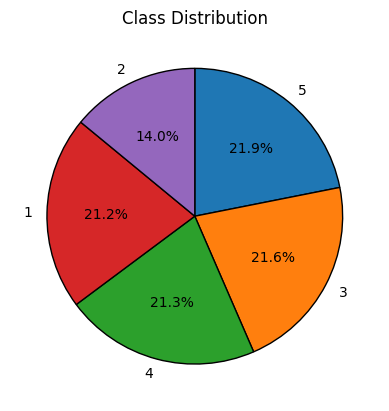

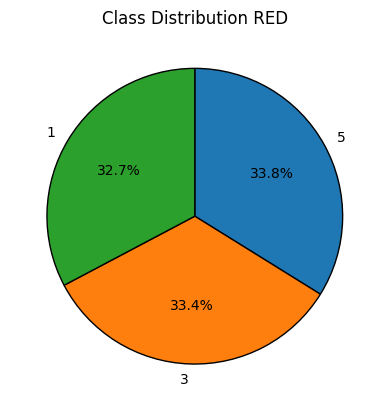

In [40]:
class_counts = df["Valoraciones"].value_counts()

# Create pie chart with black border and pastel colors
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90,
        counterclock=False, wedgeprops={'edgecolor': 'black', 'linewidth': 1})

# Add title
plt.title('Class Distribution')

# Show the plot
plt.show()


class_counts = df_red["Valoraciones"].value_counts()

# Create pie chart with black border and pastel colors
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90,
        counterclock=False, wedgeprops={'edgecolor': 'black', 'linewidth': 1})

# Add title
plt.title('Class Distribution RED')

# Show the plot
plt.show()


In [43]:
from sklearn import model_selection
from sklearn import feature_extraction

X = df.loc[:,"Texto"]
y = df.loc[:,"Valoraciones"]

X_red = df_red.loc[:, "Texto"]
y_red = df_red.loc[:, "ValoracionesReducido"]
accuracies = {}

X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = feature_extraction.text.CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


## Naive Bayes (Multinomial)

Naive Bayes:
Precision con multinomialNB:  0.5061188811188811


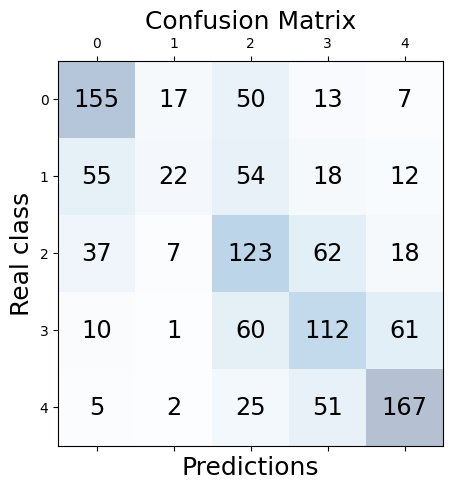

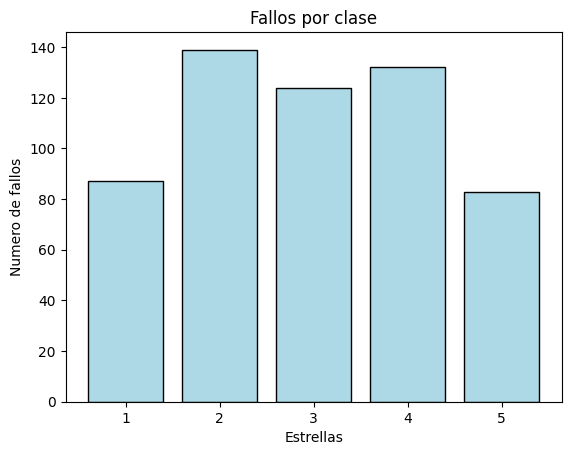

In [41]:
from scipy.stats import uniform, randint, loguniform
from sklearn.naive_bayes import MultinomialNB

print("Naive Bayes:")

clf = MultinomialNB()
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

acc = metrics.accuracy_score(y_test, y_pred)
accuracies["multinominalNB"] = acc

print("Precision con multinomialNB: ", acc)

confusion(y_test, y_pred)
mostrarFallos(y_test, y_pred)


## Logistic regression

/home/pelikan/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mejores paramtros:  {'C': 0.7}
Mejores precision en train:  0.4784591837954825
Precision con LogisticRegression:  0.47465034965034963


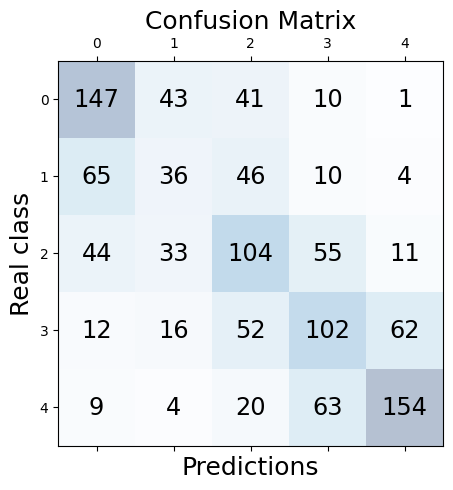

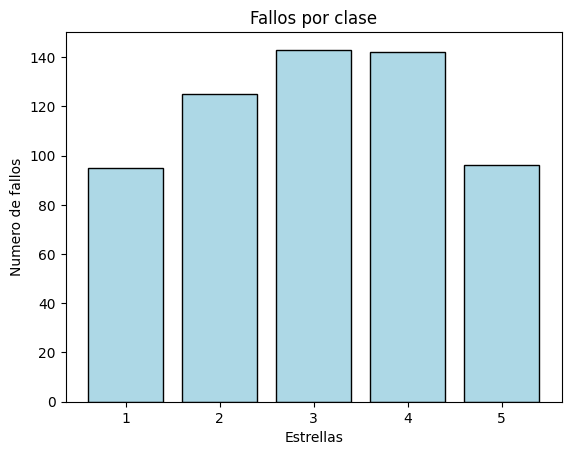

In [35]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression(max_iter=500)

rvs = loguniform.rvs(0.5, 7, size=100000)
rvs = np.round(rvs, decimals=1)
param_dist = {'C': rvs}

modelos_rand =  model_selection.RandomizedSearchCV(clf,param_dist,n_jobs=-1)
modelos_rand.fit(X_train_vec, y_train)
print("Mejores paramtros: ", modelos_rand.best_params_)
print("Mejores precision en train: ", modelos_rand.best_score_)

y_pred = modelos_rand.best_estimator_.predict(X_test_vec)
acc = metrics.accuracy_score(y_test, y_pred)
accuracies["LogisticRegression"] = acc
print("Precision con LogisticRegression: ", acc)

confusion(y_test, y_pred)
mostrarFallos(y_test, y_pred)


## SVM

SVM:
Mejores paramtros:  {'kernel': 'rbf', 'C': 1.5}
Mejores precision en train:  0.48785904748239295
Precision con SVM (test):  0.48426573426573427


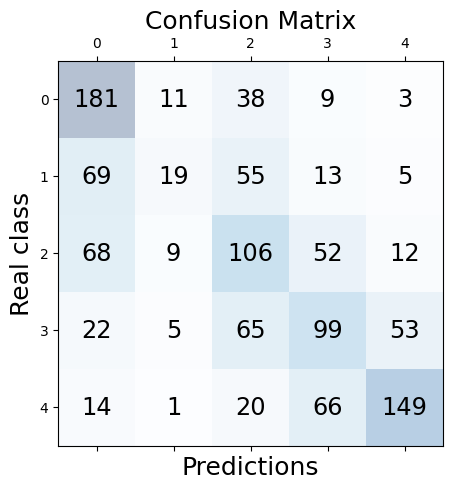

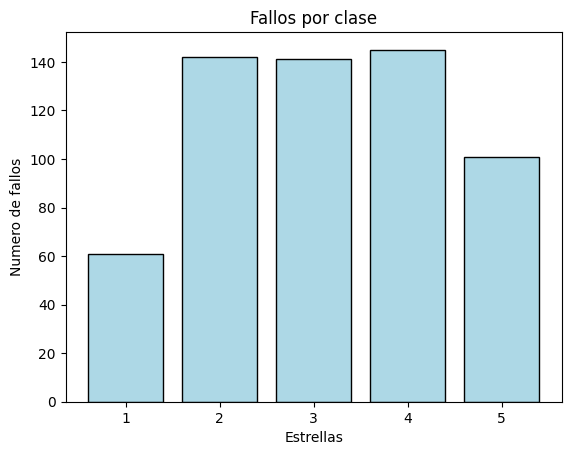

In [36]:
from sklearn.svm import SVC

print("SVM:")

clf = SVC()

rvs = loguniform.rvs(0.5, 7, size=100000)
rvs = np.round(rvs, decimals=1)
param_dist = {'C': rvs, 'kernel': ['linear','rbf']}

modelos_rand =  model_selection.RandomizedSearchCV(clf,param_dist,n_jobs=-1)

modelos_rand.fit(X_train_vec, y_train)
print("Mejores paramtros: ", modelos_rand.best_params_)
print("Mejores precision en train: ", modelos_rand.best_score_)

y_pred = modelos_rand.best_estimator_.predict(X_test_vec)
acc = metrics.accuracy_score(y_test, y_pred)
accuracies["SVM"] = acc

print("Precision con SVM (test): ", acc)

confusion(y_test, y_pred)
mostrarFallos(y_test, y_pred)


## MLP


Redes Neuronales (MLP):


/home/pelikan/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Precision con MLP (test):  0.5052447552447552


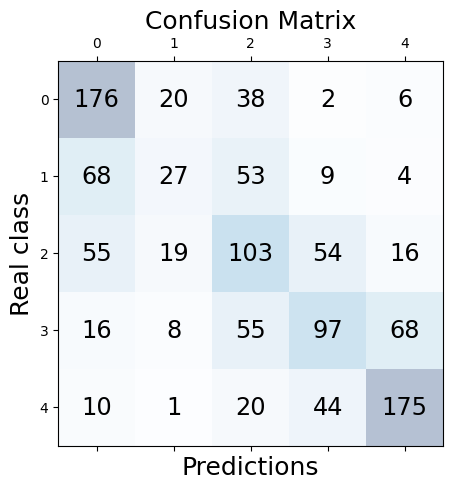

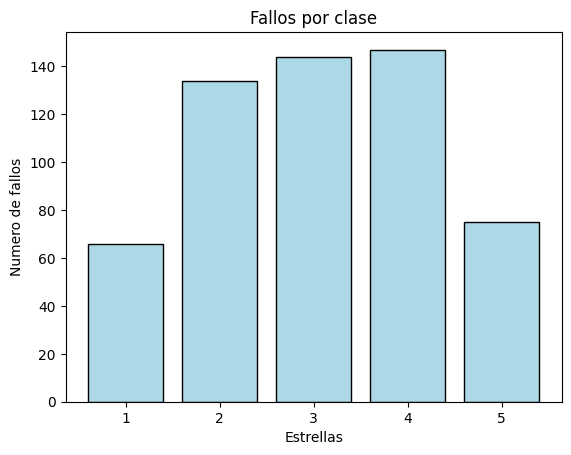

In [37]:
from sklearn.neural_network import MLPClassifier

print("Redes Neuronales (MLP):")


clf = MLPClassifier( hidden_layer_sizes=(344,), solver="sgd").fit(X_train_vec, y_train)


y_pred = clf.predict(X_test_vec)
acc = metrics.accuracy_score(y_test, y_pred)
accuracies["MLP"] = acc

print("Precision con MLP (test): ", acc)

confusion(y_test, y_pred)
mostrarFallos(y_test, y_pred)


## Reduced valorations MLP classifier

Redes Neuronales Con Valoraciones reducidas:


/home/pelikan/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Precision con MLP (test):  0.7162162162162162


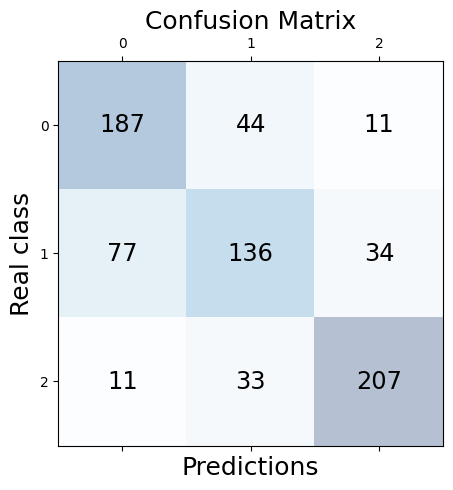

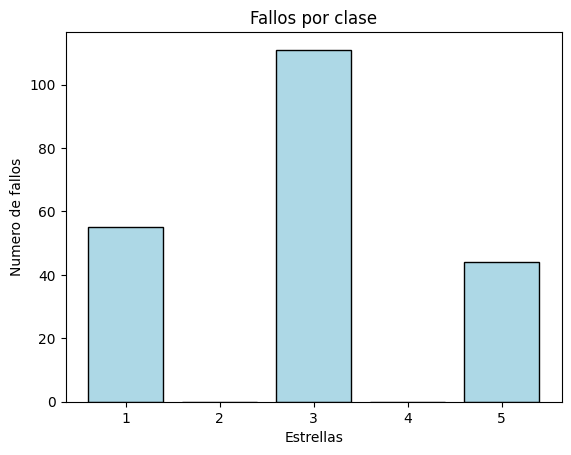

In [44]:
print("Redes Neuronales Con Valoraciones reducidas:")

X_resto_red, X_test_red, y_train_red, y_test_red = model_selection.train_test_split(X_red, y_red, test_size=0.2, random_state=42, stratify=y_red)
vectorizer = feature_extraction.text.CountVectorizer()
X_train_vec_red = vectorizer.fit_transform(X_resto_red)
X_test_vec_red = vectorizer.transform(X_test_red)


clf = MLPClassifier(hidden_layer_sizes=(344,), solver="sgd").fit(X_train_vec_red, y_train_red)


y_pred_red = clf.predict(X_test_vec_red)
acc = metrics.accuracy_score(y_test_red, y_pred_red)
accuracies["MLP_RED"] = acc

print("Precision con MLP (test): ", acc)

confusion(y_test_red, y_pred_red)
mostrarFallos(y_test_red, y_pred_red)


## Resume:

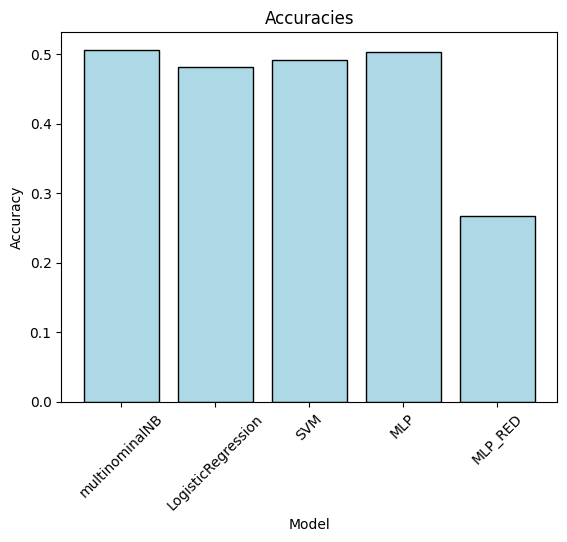

In [28]:
labels = list(accuracies.keys())
values = list(accuracies.values())

plt.bar(labels, values, edgecolor='black', color='lightblue')
plt.title('Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)  
plt.show()
